This notebook was created by Donna Faith Go.

In [1]:
import sys
!{sys.executable} -m pip install arch

   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---

In [2]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns

# data gathering
import yfinance as yf

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_acf
from statsmodels.tsa.stattools import adfuller, kpss

# GARCH model
from arch import arch_model

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# GARCH on the PSEi

This notebook aims to do volatility clustering on the Philippine Stock Exchange Composite Index (PSEi) through the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model.

## Data Gathering

In [3]:
# getting closing prices for the 30 stocks with batching
start_date = '2013-01-01'# '2019-01-01'
end_date = '2026-01-01' #'2025-08-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['PSEI.PS'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('psei closing prices.pkl')

In [4]:
filepath = r'psei closing prices.pkl'
with open(filepath, 'rb') as f:
    pse_data = pickle.load(f)
print(pse_data.index[0])
print(pse_data.index[-1])

2013-01-02 00:00:00
2025-12-29 00:00:00


## Data Preprocessing

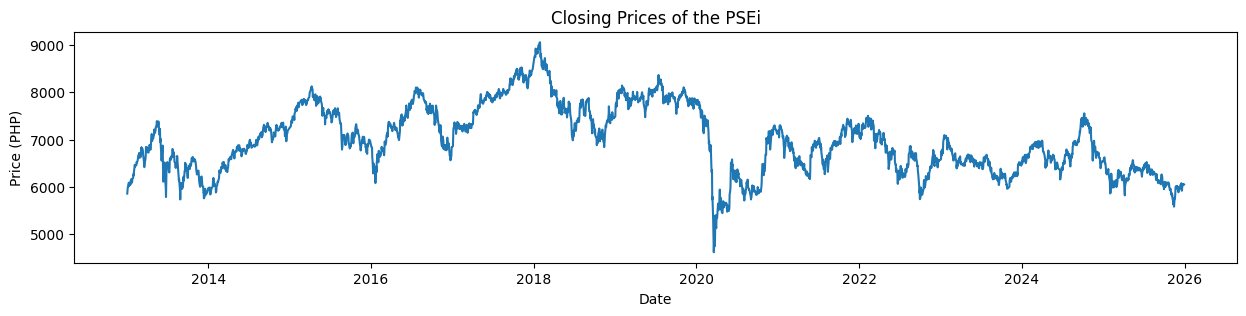

In [5]:
# plot the closing prices of the PSEi
plt.figure(figsize=(15, 3))
plt.plot(pse_data)
plt.xlabel('Date')
plt.ylabel('Price (PHP)')
plt.title('Closing Prices of the PSEi')
plt.show()

The data does not look stationary.

ADF Result: Stationary
KPSS Result: Stationary


C:\Users\Donna\AppData\Local\Temp\ipykernel_44612\460906801.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(pse_data_values)[1]


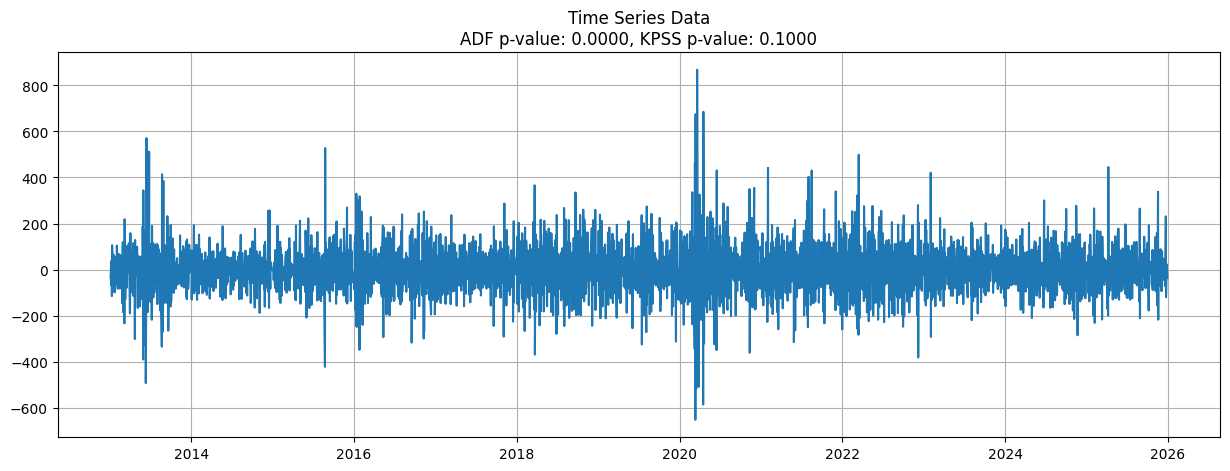

In [19]:
# turn to stationary
pse_data = pse_data.diff(1)
pse_data_values = pse_data['PSEI.PS'].dropna()

# checking for stationarity
p_value = 0.05
adf_res = adfuller(pse_data_values)[1]
kpss_res = kpss(pse_data_values)[1]

print("ADF Result:", "Stationary" if adf_res < p_value else "Not Stationary")
print("KPSS Result:", "Stationary" if kpss_res > p_value else "Not Stationary")

# plotting
plt.figure(figsize=(15, 5))
plt.plot(pse_data_values)
plt.title(f"Time Series Data\nADF p-value: {adf_res:.4f}, KPSS p-value: {kpss_res:.4f}")
plt.grid(True)
plt.show()

## Defining p, d, q